In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import storage

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
client = storage.Client()
bucket = client.get_bucket('hidden-state-genomics')

directory = {
    "ef8": [f"layer_{i}" for i in range(24)],
    "ef16": [f"layer_{i}" for i in range(24)],
    "ef32": [f"layer_{i}" for i in range(24)],
}

In [8]:
test_predictions = {}

for layer in directory["ef8"]:
    path = f"cisplatinCNNheads/ef8/{layer}"

    embedblob = bucket.blob(f"{path}/embeddings_results.csv")
    embed_file = embedblob.open("r")
    embed_df = pd.read_csv(embed_file, index_col=0)

    def convert_string_to_list_of_int(string: str):
        string = string.strip("[]")
        string = string.split(", ")
        return [int(x) for x in string]

    embed_df["actual"] = embed_df["actual"].apply(convert_string_to_list_of_int)
    embed_df["predicted"] = embed_df["predicted"].apply(convert_string_to_list_of_int)

    featblob = bucket.blob(f"{path}/features_results.csv")
    feat_file = featblob.open("r")
    feat_df = pd.read_csv(feat_file, index_col=0)

    feat_df["actual"] = feat_df["actual"].apply(convert_string_to_list_of_int)
    feat_df["predicted"] = feat_df["predicted"].apply(convert_string_to_list_of_int)

    results = {
        "embed": {
            "actual": [],
            "predicted": [],
        },
        "features": {
            "actual": [],
            "predicted": [],
        }
    }

    for row in embed_df["actual"]:
        results["embed"]["actual"].extend(row)
    for row in embed_df["predicted"]:
        results["embed"]["predicted"].extend(row)
    for row in feat_df["actual"]:
        results["features"]["actual"].extend(row)
    for row in feat_df["predicted"]:
        results["features"]["predicted"].extend(row)

    test_predictions[layer] = results


       Layer  Accuracy       Type
0    layer_0  0.989573  Embedding
1    layer_1  0.988143  Embedding
2    layer_2  0.977300  Embedding
3    layer_3  0.984986  Embedding
4    layer_4  0.988382  Embedding
5    layer_5  0.988441  Embedding
6    layer_6  0.987667  Embedding
7    layer_7  0.987369  Embedding
8    layer_8  0.981053  Embedding
9    layer_9  0.988680  Embedding
10  layer_10  0.987190  Embedding
11  layer_11  0.987965  Embedding
12  layer_12  0.988501  Embedding
13  layer_13  0.986714  Embedding
14  layer_14  0.987548  Embedding
15  layer_15  0.986475  Embedding
16  layer_16  0.982781  Embedding
17  layer_17  0.982960  Embedding
18  layer_18  0.987726  Embedding
19  layer_19  0.986952  Embedding
20  layer_20  0.988382  Embedding
21  layer_21  0.984449  Embedding
22  layer_22  0.985879  Embedding
23  layer_23  0.987369  Embedding
24   layer_0  0.843601    Feature
25   layer_1  0.939943    Feature
26   layer_2  0.918077    Feature
27   layer_3  0.855815    Feature
28   layer_4  

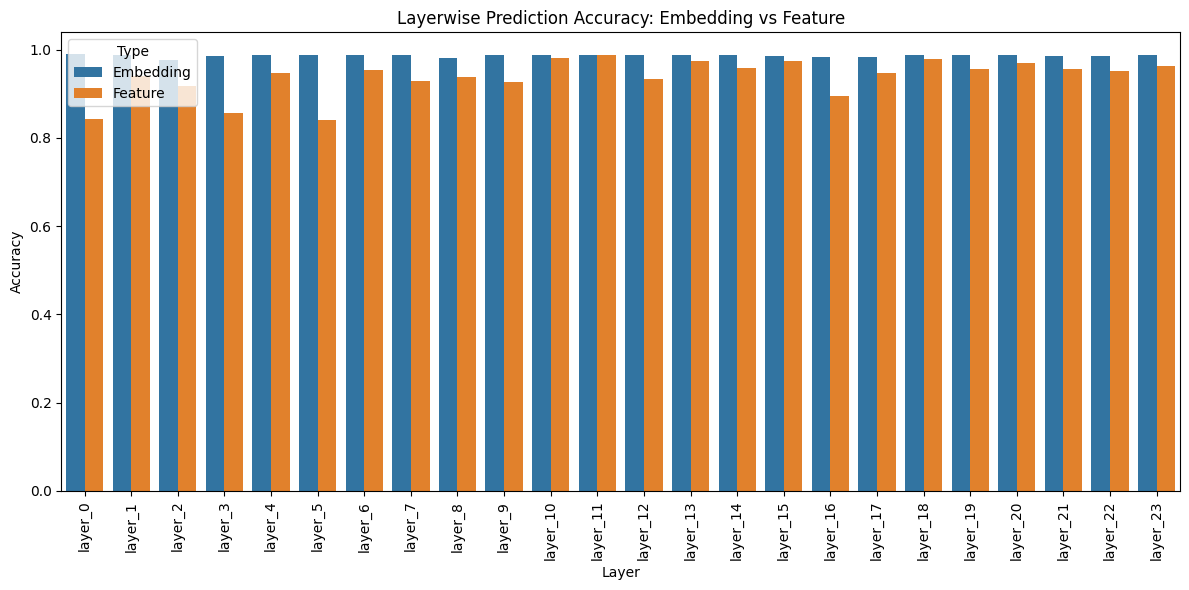

In [9]:
embed_accuracies = []
feat_accuracies = []
layers = directory["ef8"]

for lyr in layers:
    embed_actual = test_predictions[lyr]["embed"]["actual"]
    embed_pred = test_predictions[lyr]["embed"]["predicted"]
    feat_actual = test_predictions[lyr]["features"]["actual"]
    feat_pred = test_predictions[lyr]["features"]["predicted"]

    embed_accuracies.append(accuracy_score(embed_actual, embed_pred))
    feat_accuracies.append(accuracy_score(feat_actual, feat_pred))

plot_df = pd.DataFrame({
    "Layer": layers * 2,
    "Accuracy": embed_accuracies + feat_accuracies,
    "Type": ["Embedding"] * len(layers) + ["Feature"] * len(layers)
})

print(plot_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Layer", y="Accuracy", hue="Type")
plt.xticks(rotation=90)
plt.title("Layerwise Prediction Accuracy: Embedding vs Feature")
plt.tight_layout()
plt.show()


       Layer  Precision       Type
0    layer_0   0.980456  Embedding
1    layer_1   0.977835  Embedding
2    layer_2   0.958406  Embedding
3    layer_3   0.980503  Embedding
4    layer_4   0.978271  Embedding
5    layer_5   0.978380  Embedding
6    layer_6   0.977496  Embedding
7    layer_7   0.976421  Embedding
8    layer_8   0.965043  Embedding
9    layer_9   0.978816  Embedding
10  layer_10   0.976095  Embedding
11  layer_11   0.977508  Embedding
12  layer_12   0.978595  Embedding
13  layer_13   0.975228  Embedding
14  layer_14   0.977384  Embedding
15  layer_15   0.979157  Embedding
16  layer_16   0.968130  Embedding
17  layer_17   0.981081  Embedding
18  layer_18   0.977179  Embedding
19  layer_19   0.975873  Embedding
20  layer_20   0.978697  Embedding
21  layer_21   0.971441  Embedding
22  layer_22   0.974872  Embedding
23  layer_23   0.976421  Embedding
24   layer_0   0.770529    Feature
25   layer_1   0.907328    Feature
26   layer_2   0.868285    Feature
27   layer_3   0.809

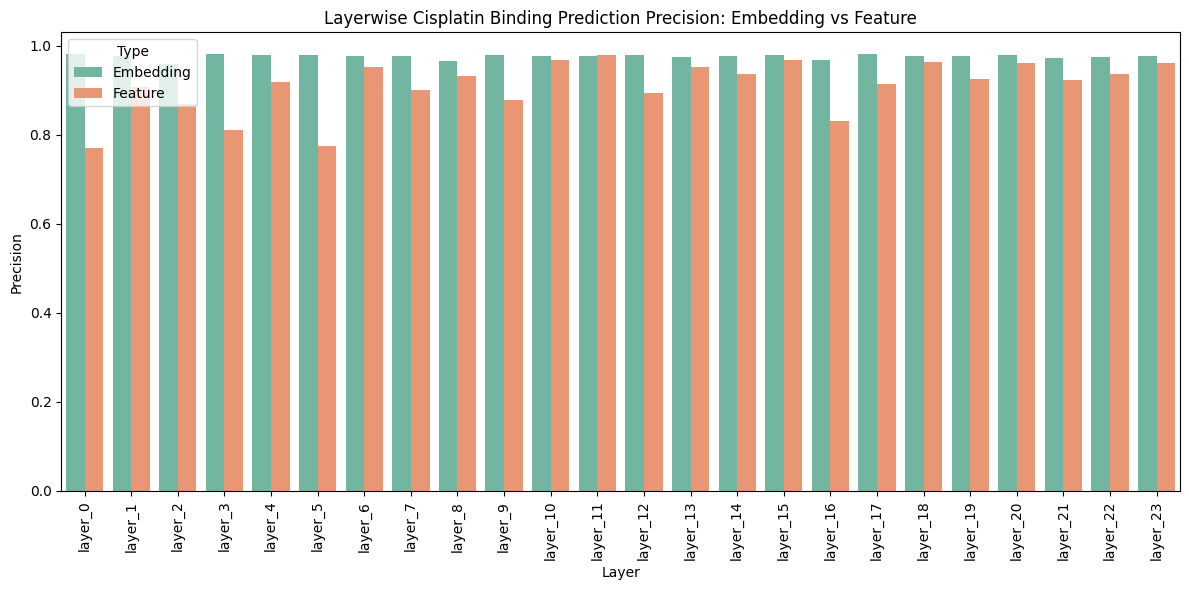

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

embed_accuracies = []
feat_accuracies = []
layers = directory["ef8"]

for lyr in layers:
    embed_actual = test_predictions[lyr]["embed"]["actual"]
    embed_pred = test_predictions[lyr]["embed"]["predicted"]
    feat_actual = test_predictions[lyr]["features"]["actual"]
    feat_pred = test_predictions[lyr]["features"]["predicted"]

    embed_accuracies.append(precision_score(embed_actual, embed_pred))
    feat_accuracies.append(precision_score(feat_actual, feat_pred))

plot_df = pd.DataFrame({
    "Layer": layers * 2,
    "Precision": embed_accuracies + feat_accuracies,
    "Type": ["Embedding"] * len(layers) + ["Feature"] * len(layers)
})

print(plot_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Layer", y="Precision", hue="Type", palette="Set2")
plt.xticks(rotation=90)
plt.title("Layerwise Cisplatin Binding Prediction Precision: Embedding vs Feature")
plt.tight_layout()
plt.show()

       Layer    Recall       Type
0    layer_0  1.000000  Embedding
1    layer_1  1.000000  Embedding
2    layer_2  1.000000  Embedding
3    layer_3  0.991001  Embedding
4    layer_4  1.000000  Embedding
5    layer_5  1.000000  Embedding
6    layer_6  0.999430  Embedding
7    layer_7  1.000000  Embedding
8    layer_8  1.000000  Embedding
9    layer_9  1.000000  Embedding
10  layer_10  1.000000  Embedding
11  layer_11  1.000000  Embedding
12  layer_12  0.999886  Embedding
13  layer_13  1.000000  Embedding
14  layer_14  0.999317  Embedding
15  layer_15  0.995330  Embedding
16  layer_16  1.000000  Embedding
17  layer_17  0.986445  Embedding
18  layer_18  0.999886  Embedding
19  layer_19  0.999772  Embedding
20  layer_20  0.999544  Embedding
21  layer_21  0.999658  Embedding
22  layer_22  0.998747  Embedding
23  layer_23  1.000000  Embedding
24   layer_0  0.998291    Feature
25   layer_1  0.985875    Feature
26   layer_2  0.994191    Feature
27   layer_3  0.946349    Feature
28   layer_4  

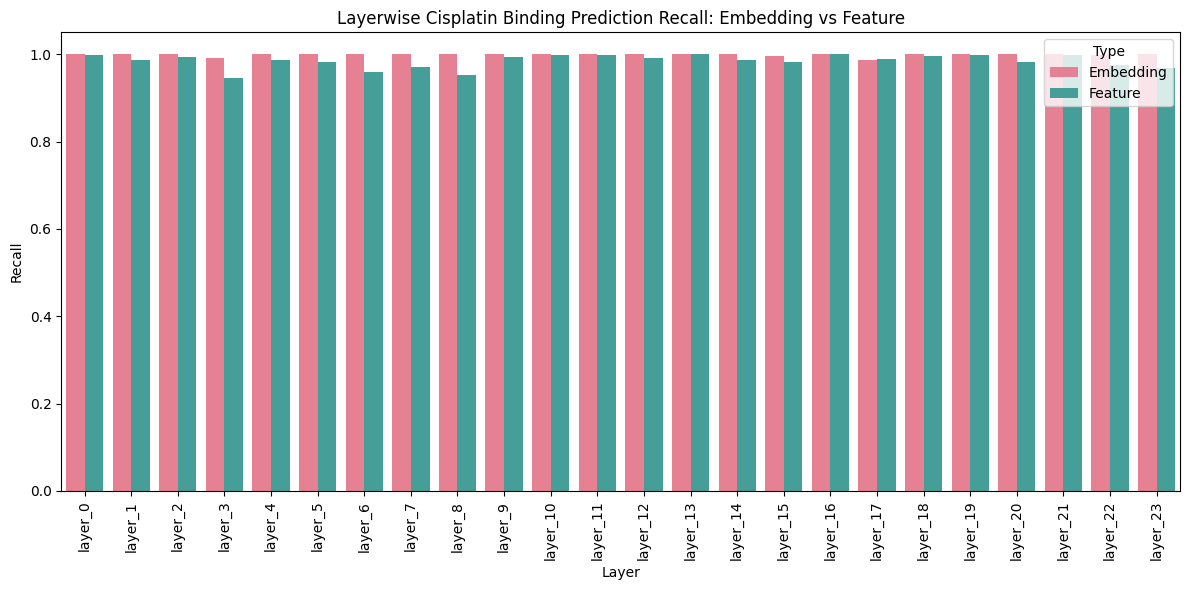

In [22]:
embed_accuracies = []
feat_accuracies = []
layers = directory["ef8"]

for lyr in layers:
    embed_actual = test_predictions[lyr]["embed"]["actual"]
    embed_pred = test_predictions[lyr]["embed"]["predicted"]
    feat_actual = test_predictions[lyr]["features"]["actual"]
    feat_pred = test_predictions[lyr]["features"]["predicted"]

    embed_accuracies.append(recall_score(embed_actual, embed_pred))
    feat_accuracies.append(recall_score(feat_actual, feat_pred))

plot_df = pd.DataFrame({
    "Layer": layers * 2,
    "Recall": embed_accuracies + feat_accuracies,
    "Type": ["Embedding"] * len(layers) + ["Feature"] * len(layers)
})

print(plot_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Layer", y="Recall", hue="Type", palette="husl")
plt.xticks(rotation=90)
plt.title("Layerwise Cisplatin Binding Prediction Recall: Embedding vs Feature")
plt.tight_layout()
plt.show()

       Layer  F1 Score       Type
0    layer_0  0.990131  Embedding
1    layer_1  0.988793  Embedding
2    layer_2  0.978761  Embedding
3    layer_3  0.985724  Embedding
4    layer_4  0.989016  Embedding
5    layer_5  0.989072  Embedding
6    layer_6  0.988341  Embedding
7    layer_7  0.988070  Embedding
8    layer_8  0.982211  Embedding
9    layer_9  0.989295  Embedding
10  layer_10  0.987903  Embedding
11  layer_11  0.988626  Embedding
12  layer_12  0.989126  Embedding
13  layer_13  0.987459  Embedding
14  layer_14  0.988229  Embedding
15  layer_15  0.987177  Embedding
16  layer_16  0.983807  Embedding
17  layer_17  0.983756  Embedding
18  layer_18  0.988402  Embedding
19  layer_19  0.987678  Embedding
20  layer_20  0.989011  Embedding
21  layer_21  0.985348  Embedding
22  layer_22  0.986665  Embedding
23  layer_23  0.988070  Embedding
24   layer_0  0.869746    Feature
25   layer_1  0.944972    Feature
26   layer_2  0.926982    Feature
27   layer_3  0.872872    Feature
28   layer_4  

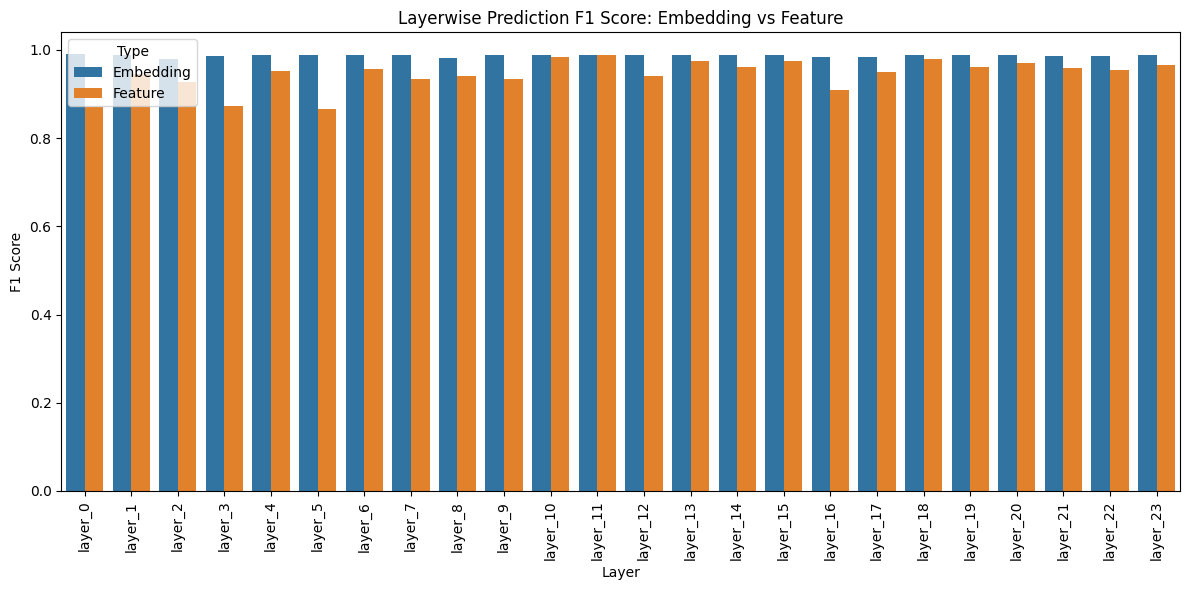

In [23]:
embed_accuracies = []
feat_accuracies = []
layers = directory["ef8"]

for lyr in layers:
    embed_actual = test_predictions[lyr]["embed"]["actual"]
    embed_pred = test_predictions[lyr]["embed"]["predicted"]
    feat_actual = test_predictions[lyr]["features"]["actual"]
    feat_pred = test_predictions[lyr]["features"]["predicted"]

    embed_accuracies.append(f1_score(embed_actual, embed_pred))
    feat_accuracies.append(f1_score(feat_actual, feat_pred))

plot_df = pd.DataFrame({
    "Layer": layers * 2,
    "F1 Score": embed_accuracies + feat_accuracies,
    "Type": ["Embedding"] * len(layers) + ["Feature"] * len(layers)
})

print(plot_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Layer", y="F1 Score", hue="Type", palette="tab10")
plt.xticks(rotation=90)
plt.title("Layerwise Prediction F1 Score: Embedding vs Feature")
plt.tight_layout()
plt.show()

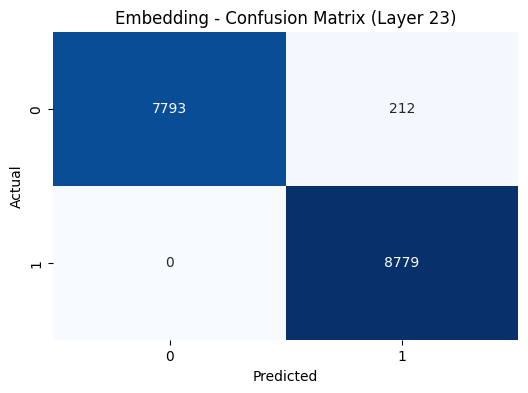


Embedding - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      8005
           1       0.98      1.00      0.99      8779

    accuracy                           0.99     16784
   macro avg       0.99      0.99      0.99     16784
weighted avg       0.99      0.99      0.99     16784



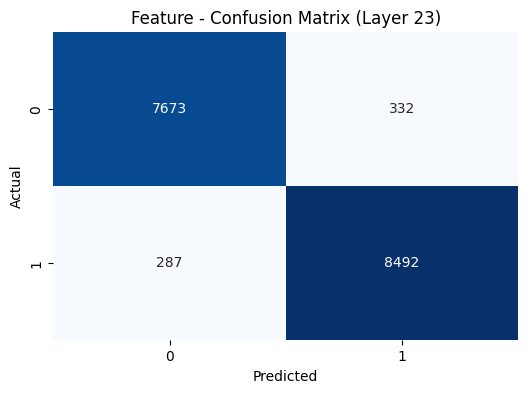


Feature - Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      8005
           1       0.96      0.97      0.96      8779

    accuracy                           0.96     16784
   macro avg       0.96      0.96      0.96     16784
weighted avg       0.96      0.96      0.96     16784



In [10]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix and classification report for layer 23 (last layer)
embed_actual = test_predictions["layer_23"]["embed"]["actual"]
embed_pred = test_predictions["layer_23"]["embed"]["predicted"]
feat_actual = test_predictions["layer_23"]["features"]["actual"]
feat_pred = test_predictions["layer_23"]["features"]["predicted"]

# Embedding predictions
embed_cm = confusion_matrix(embed_actual, embed_pred)
embed_report = classification_report(embed_actual, embed_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(embed_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Embedding - Confusion Matrix (Layer 23)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Embedding - Confusion Matrix:\n", embed_cm)
print("\nEmbedding - Classification Report:\n", embed_report)

# Feature predictions
feat_cm = confusion_matrix(feat_actual, feat_pred)
feat_report = classification_report(feat_actual, feat_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(feat_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Feature - Confusion Matrix (Layer 23)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Feature - Confusion Matrix:\n", feat_cm)
print("\nFeature - Classification Report:\n", feat_report)

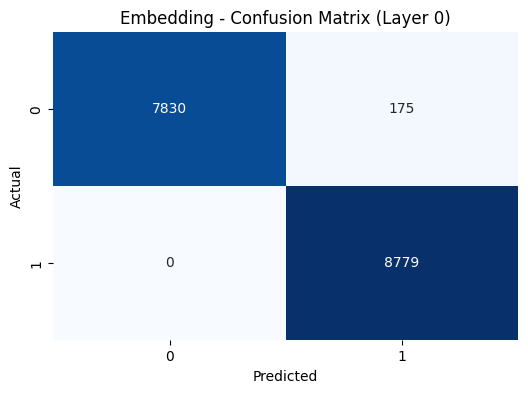


Embedding - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      8005
           1       0.98      1.00      0.99      8779

    accuracy                           0.99     16784
   macro avg       0.99      0.99      0.99     16784
weighted avg       0.99      0.99      0.99     16784



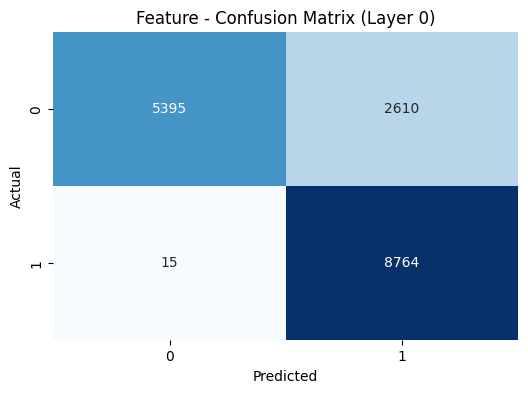


Feature - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80      8005
           1       0.77      1.00      0.87      8779

    accuracy                           0.84     16784
   macro avg       0.88      0.84      0.84     16784
weighted avg       0.88      0.84      0.84     16784



In [12]:
# Confusion matrix and classification report for layer 0 (first layer)
embed_actual = test_predictions["layer_0"]["embed"]["actual"]
embed_pred = test_predictions["layer_0"]["embed"]["predicted"]
feat_actual = test_predictions["layer_0"]["features"]["actual"]
feat_pred = test_predictions["layer_0"]["features"]["predicted"]

# Embedding predictions
embed_cm = confusion_matrix(embed_actual, embed_pred)
embed_report = classification_report(embed_actual, embed_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(embed_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Embedding - Confusion Matrix (Layer 0)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Embedding - Confusion Matrix:\n", embed_cm)
print("\nEmbedding - Classification Report:\n", embed_report)

# Feature predictions
feat_cm = confusion_matrix(feat_actual, feat_pred)
feat_report = classification_report(feat_actual, feat_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(feat_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Feature - Confusion Matrix (Layer 0)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Feature - Confusion Matrix:\n", feat_cm)
print("\nFeature - Classification Report:\n", feat_report)

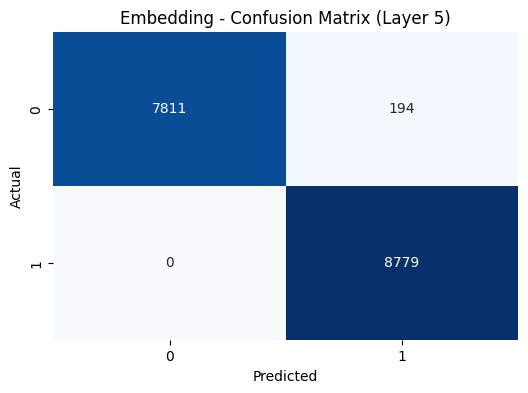


Embedding - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      8005
           1       0.98      1.00      0.99      8779

    accuracy                           0.99     16784
   macro avg       0.99      0.99      0.99     16784
weighted avg       0.99      0.99      0.99     16784



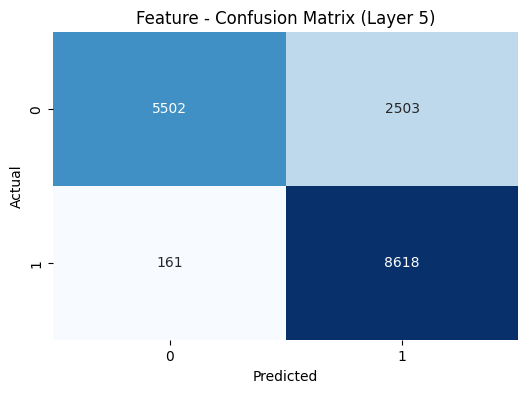


Feature - Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.69      0.81      8005
           1       0.77      0.98      0.87      8779

    accuracy                           0.84     16784
   macro avg       0.87      0.83      0.84     16784
weighted avg       0.87      0.84      0.84     16784



In [13]:
# Confusion matrix and classification report for layer 5
embed_actual = test_predictions["layer_5"]["embed"]["actual"]
embed_pred = test_predictions["layer_5"]["embed"]["predicted"]
feat_actual = test_predictions["layer_5"]["features"]["actual"]
feat_pred = test_predictions["layer_5"]["features"]["predicted"]

# Embedding predictions
embed_cm = confusion_matrix(embed_actual, embed_pred)
embed_report = classification_report(embed_actual, embed_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(embed_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Embedding - Confusion Matrix (Layer 5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Embedding - Confusion Matrix:\n", embed_cm)
print("\nEmbedding - Classification Report:\n", embed_report)

# Feature predictions
feat_cm = confusion_matrix(feat_actual, feat_pred)
feat_report = classification_report(feat_actual, feat_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(feat_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Feature - Confusion Matrix (Layer 5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Feature - Confusion Matrix:\n", feat_cm)
print("\nFeature - Classification Report:\n", feat_report)

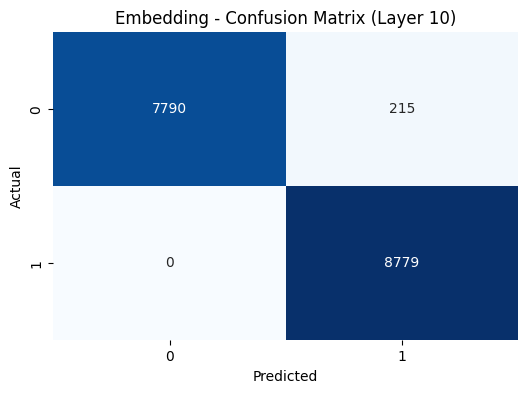


Embedding - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      8005
           1       0.98      1.00      0.99      8779

    accuracy                           0.99     16784
   macro avg       0.99      0.99      0.99     16784
weighted avg       0.99      0.99      0.99     16784



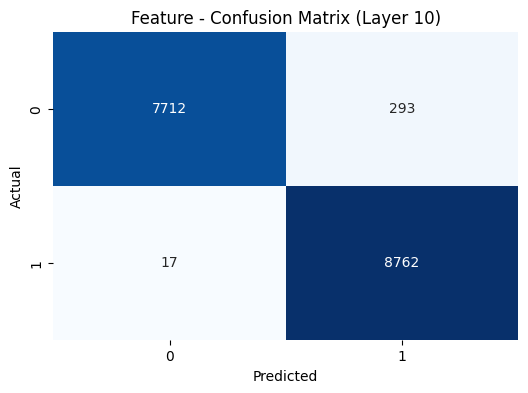


Feature - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      8005
           1       0.97      1.00      0.98      8779

    accuracy                           0.98     16784
   macro avg       0.98      0.98      0.98     16784
weighted avg       0.98      0.98      0.98     16784



In [15]:
# Confusion matrix and classification report for layer 10
embed_actual = test_predictions["layer_10"]["embed"]["actual"]
embed_pred = test_predictions["layer_10"]["embed"]["predicted"]
feat_actual = test_predictions["layer_10"]["features"]["actual"]
feat_pred = test_predictions["layer_10"]["features"]["predicted"]

# Embedding predictions
embed_cm = confusion_matrix(embed_actual, embed_pred)
embed_report = classification_report(embed_actual, embed_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(embed_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Embedding - Confusion Matrix (Layer 10)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Embedding - Confusion Matrix:\n", embed_cm)
print("\nEmbedding - Classification Report:\n", embed_report)

# Feature predictions
feat_cm = confusion_matrix(feat_actual, feat_pred)
feat_report = classification_report(feat_actual, feat_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(feat_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Feature - Confusion Matrix (Layer 10)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Feature - Confusion Matrix:\n", feat_cm)
print("\nFeature - Classification Report:\n", feat_report)

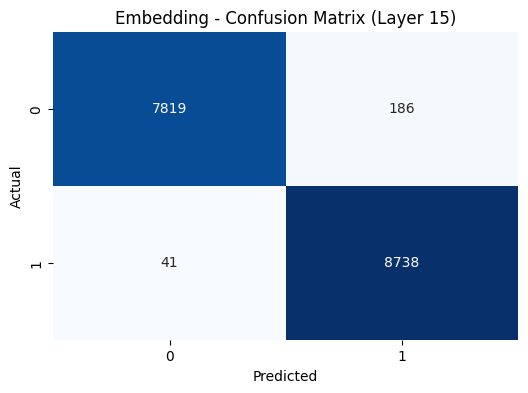


Embedding - Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      8005
           1       0.98      1.00      0.99      8779

    accuracy                           0.99     16784
   macro avg       0.99      0.99      0.99     16784
weighted avg       0.99      0.99      0.99     16784



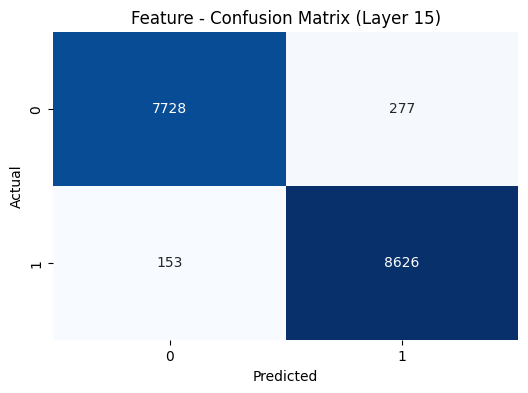


Feature - Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      8005
           1       0.97      0.98      0.98      8779

    accuracy                           0.97     16784
   macro avg       0.97      0.97      0.97     16784
weighted avg       0.97      0.97      0.97     16784



In [14]:
# Confusion matrix and classification report for layer 15
embed_actual = test_predictions["layer_15"]["embed"]["actual"]
embed_pred = test_predictions["layer_15"]["embed"]["predicted"]
feat_actual = test_predictions["layer_15"]["features"]["actual"]
feat_pred = test_predictions["layer_15"]["features"]["predicted"]

# Embedding predictions
embed_cm = confusion_matrix(embed_actual, embed_pred)
embed_report = classification_report(embed_actual, embed_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(embed_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Embedding - Confusion Matrix (Layer 15)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Embedding - Confusion Matrix:\n", embed_cm)
print("\nEmbedding - Classification Report:\n", embed_report)

# Feature predictions
feat_cm = confusion_matrix(feat_actual, feat_pred)
feat_report = classification_report(feat_actual, feat_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(feat_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Feature - Confusion Matrix (Layer 15)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Feature - Confusion Matrix:\n", feat_cm)
print("\nFeature - Classification Report:\n", feat_report)

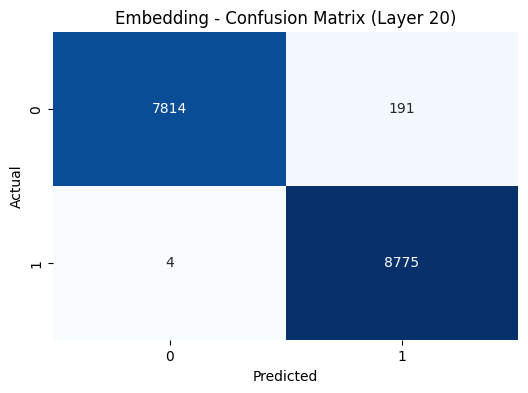


Embedding - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      8005
           1       0.98      1.00      0.99      8779

    accuracy                           0.99     16784
   macro avg       0.99      0.99      0.99     16784
weighted avg       0.99      0.99      0.99     16784



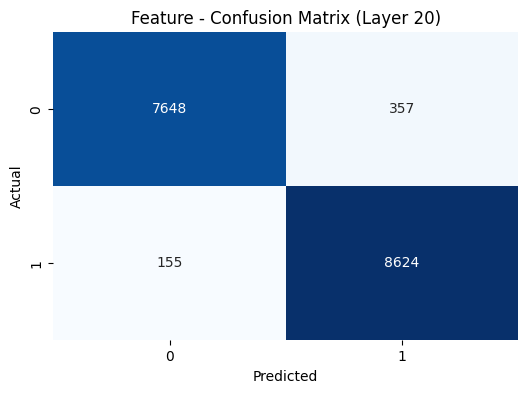


Feature - Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      8005
           1       0.96      0.98      0.97      8779

    accuracy                           0.97     16784
   macro avg       0.97      0.97      0.97     16784
weighted avg       0.97      0.97      0.97     16784



In [16]:
# Confusion matrix and classification report for layer 20
embed_actual = test_predictions["layer_20"]["embed"]["actual"]
embed_pred = test_predictions["layer_20"]["embed"]["predicted"]
feat_actual = test_predictions["layer_20"]["features"]["actual"]
feat_pred = test_predictions["layer_20"]["features"]["predicted"]

# Embedding predictions
embed_cm = confusion_matrix(embed_actual, embed_pred)
embed_report = classification_report(embed_actual, embed_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(embed_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Embedding - Confusion Matrix (Layer 20)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Embedding - Confusion Matrix:\n", embed_cm)
print("\nEmbedding - Classification Report:\n", embed_report)

# Feature predictions
feat_cm = confusion_matrix(feat_actual, feat_pred)
feat_report = classification_report(feat_actual, feat_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(feat_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Feature - Confusion Matrix (Layer 20)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#print("Feature - Confusion Matrix:\n", feat_cm)
print("\nFeature - Classification Report:\n", feat_report)